In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
import kagglehub
path = kagglehub.dataset_download("tongpython/cat-and-dog")

In [ ]:
from pathlib import Path
path = Path(path)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from random import shuffle
from PIL import Image

class cats_dogs(Dataset):
  def __init__(self, folder, transform=None, n=500):
    cats = (folder / "cats").glob("*.jpg")
    dogs = (folder / "dogs").glob("*.jpg")
    self.fpaths = list(cats)[:n] + list(dogs)[:n]
    shuffle(self.fpaths)
    self.targets = [int(f.stem.startswith("dog")) for f in self.fpaths] # dog=1 & cat=0
    self.transform = transform

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    target = self.targets[ix]
    target = np.array(target).astype(np.float32)
    image = Image.open(self.fpaths[ix])
    if self.transform:
      image = self.transform(image)
    return image, target

In [ ]:
import timm

In [ ]:
model = timm.create_model("vgg16", pretrained=True)

In [ ]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)

In [ ]:
train_data_dir = path / "training_set" / "training_set"
test_data_dir = path / "test_set" / "test_set"

In [ ]:
data = cats_dogs(train_data_dir, transform=transform)
len(data)

1000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


0.0


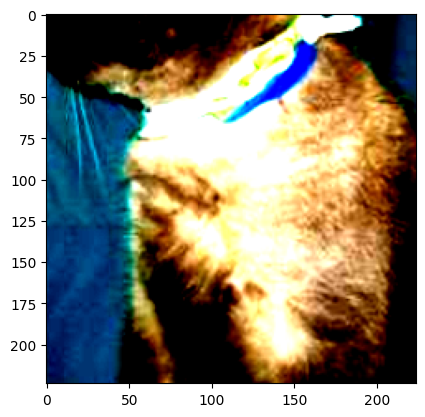

In [ ]:
im, label = data[200] 
plt.imshow(im.permute(1,2,0).cpu()) 
print(label)

In [ ]:
from torchinfo import summary

In [ ]:
model = timm.create_model("vgg16", pretrained=True)
for param in model.parameters(): 
    param.requires_grad = False
model.pre_logits = nn.AdaptiveAvgPool2d(output_size=(1,1))  # (batch_size, 512, 1, 1)
model.head = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(512, 128), 
    nn.ReLU(), 
    nn.Dropout(0.2), 
    nn.Linear(128, 1), 
    nn.Sigmoid()
)  # (batch_size, 1)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [ ]:
def get_model():
    model = timm.create_model("vgg16", pretrained=True)
    for param in model.parameters(): 
        param.requires_grad = False
    model.pre_logits = nn.AdaptiveAvgPool2d(output_size=(1,1))  # (batch_size, 512, 1, 1)
    model.head = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(512, 128), 
        nn.ReLU(), 
        nn.Dropout(0.2), 
        nn.Linear(128, 1), 
        nn.Sigmoid()
    )  # (batch_size, 1)
    model = model.to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, optimizer, loss_fn):
    prediction = model(x).squeeze()
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x).squeeze()
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = cats_dogs(train_data_dir, transform=transform)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir, transform=transform, n=9999)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x).squeeze()
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
from tqdm import tqdm

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):

    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in tqdm(enumerate(iter(trn_dl)), total=len(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        loss_val = val_loss(x, y, model)
        val_epoch_losses.append(loss_val)
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    validation_loss = np.array(val_epoch_losses).mean()
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(train_epoch_loss)
    print(train_epoch_accuracy)
    print(validation_loss)
    print(val_epoch_accuracy)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0


100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


0.25610627822818294
0.9727822580645161
0.08698284212085935
0.9751984126984127
1


100%|██████████| 31/31 [00:04<00:00,  6.88it/s]


0.05449723494389365
0.9889112903225806
0.06615200708989823
0.9747023809523809
2


100%|██████████| 31/31 [00:04<00:00,  6.72it/s]


0.03889960532767638
0.9868951612903226
0.07144673217442774
0.9737103174603174
3


100%|██████████| 31/31 [00:04<00:00,  6.71it/s]


0.0367207701182774
0.9919354838709677
0.05425939881168897
0.9801587301587301
4


100%|██████████| 31/31 [00:05<00:00,  5.99it/s]


0.022409371430835417
0.9959677419354839
0.05151778568572823
0.9801587301587301


In [ ]:
results = dict(
    train_losses = train_losses,
    train_accuracies = train_accuracies,
    val_losses = val_losses,
    val_accuracies = val_accuracies
)

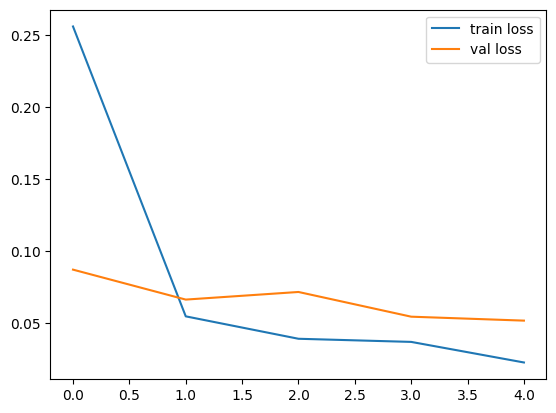

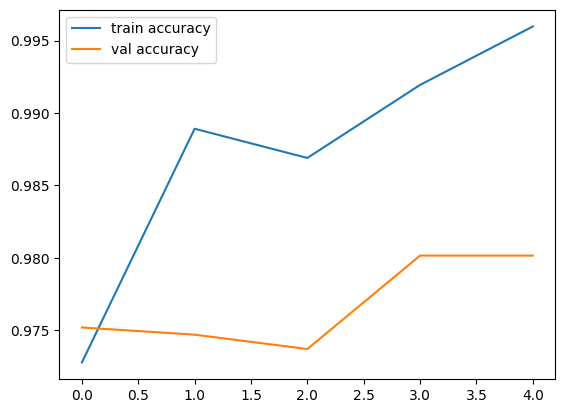

In [ ]:
plt.plot(results["train_losses"], label="train loss")
plt.plot(results["val_losses"], label="val loss")
plt.legend()
plt.show()

plt.plot(results["train_accuracies"], label="train accuracy")
plt.plot(results["val_accuracies"], label="val accuracy")
plt.legend()
plt.show()